![](img/573_banner.png)

# Lecture 3: Feature engineering

UBC Master of Data Science program, 2022-23

Instructor: Varada Kolhatkar

## Imports and LO

### Imports

In [1]:
import os
import sys

sys.path.append("code/.")
import matplotlib.pyplot as plt

%matplotlib inline
import mglearn
import numpy as np
import numpy.random as npr
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

### Learning outcomes 

From this lecture, students are expected to be able to:

- Explain the importance of the quality of data. 
- Explain the importance of feature engineering when building machine learning models.  
- Explain the "column of ones" trick. 
- Explain the concept of polynomial feature transformations.  
- Apply linear models to non-linear datasets using polynomial features.
- Explain the idea of feature crosses. 
- Identify when is it appropriate to apply discretization to numeric features.  
- Carry out preliminary feature engineering on text data using `spaCy` and `nltk`. 

## Feature engineering: Motivation

## ❓❓ Questions for you

### iClicker Exercise 3.1 

**iClicker cloud join link: https://join.iclicker.com/C0P55**

**Select the most accurate option below.**

Suppose you are working on a machine learning project. If you have to prioritize one of the following in your project which of the following would it be? 

- (A) The quality and size of the data 
- (B) Most recent deep neural network model 
- (C) Most recent optimization algorithm

**V's answers: (A)**

### Garbage in, garbage out.

- Model building is interesting. But in your machine learning projects, you'll be spending more than half of your time on data preparation, feature engineering, and transformations.
- The _quality_ of the data is important. Your model is only as good as your data. 

### Activity: How can you measure quality of the data? (~3 mins)

- Write some attributes of good- and bad-quality data in 
[this Google Document](https://docs.google.com/document/d/1nsOsdO-zRwvWWwM4-6h2t7eHgIhW8FCy3ebxoT7p0HY/edit#heading=h.z9l5ophupovf).

<br><br>

### What is feature engineering?  

<blockquote>
<b>Feature engineering</b> is the process of determining which features might be useful in the model building and creating those features by transforming the given data or extracting them using alternative sources.  
<br> 
</blockquote>    

- In 571 we talked about hyperparameter tuning, which is one way to get better model performance. 
- Another way is by changing the input representation. 
- Better representation: more flexibility, higher score, we can get by with simple and more interpretable models. 
- If your features, i.e., representation is bad, whatever fancier model you build is not going to help.

### Some quotes on feature engineering 

A quote by Pedro Domingos [A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

<blockquote>
... At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. 
</blockquote>


A quote by Andrew Ng, [Machine Learning and AI via Brain simulations](https://ai.stanford.edu/~ang/slides/DeepLearning-Mar2013.pptx)

<blockquote>
Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.
</blockquote>

### Better features usually help more than a better model.
- Good features would ideally:
    - capture most important aspects of the problem
    - allow learning with few examples 
    - generalize to new scenarios.

- There is a trade-off between simple and expressive features:
    - With simple features overfitting risk is low, but scores might be low.
    - With complicated features scores can be high, but so is overfitting risk.

### The best features may be dependent on the model you use.

- Examples:
    - For counting-based methods like decision trees separate relevant groups of variable values
        - Discretization makes sense 
    - For distance-based methods like KNN, we want different class labels to be "far".
        - Standardization 
    - For regression-based methods like linear regression, we want targets to have a linear dependency on features.

#### Domain-specific transformations

In some domains there are natural transformations to do:
- Spectrograms (sound data)
- Wavelets (image data)
- Convolutions 
<!-- <center> -->

![](img/spectogram.png)

<!-- <img src="img/spectogram.png" width="800" height="800"> -->

<!-- </center> -->

[Source](https://en.wikipedia.org/wiki/Spectrogram)

In this lecture we'll talk about the following:   

- Polynomial features (change of basis)
- Feature engineering demos
    - numeric data
    - text data


<br><br><br><br>

## Polynomial feature transformations for non-linear regression

### Linear regression prediction (recap)

- Interested in predicting a scalar valued target (e.g., housing price)
- In DSCI 571, we talked about how to make predictions $\hat{y_i}$, which is the linear function of feature vector $x_i$ and weight vector $w$. 

$$\hat{y_i} = w_0 + x_{i1}w_1 + x_{i2}w_2 + \ldots + x_{id}w_d$$
$$\hat{y_i} = w_0 + \sum_{j=1}^{d}x_{ij}w_j$$

- $\hat{y_i} \rightarrow$ prediction for example $x_i$
- $w \rightarrow$ weight vector
- $w_0 \rightarrow$ bias term
- $x_{ij} \rightarrow$ $j^{th}$ component of the feature vector $x_i$
- $w_0, w_1, \ldots, w_d$ together are the parameters

### Matrix vector notation 

- The notation above is component-wise notation. 
- We also want to be able to write it as below so that we don't have to write the summation all the time.  
- In matrix form, the expression for a linear model is: 

$$\hat{y} = Xw$$
    
- Where    
    - $\hat{y} \rightarrow$ prediction vector for feature matrix $X$
    - $w \rightarrow$ weight vector

$$ \begin{bmatrix}\hat{y_1} \\ \hat{y_2} \\ \vdots \\ \hat{y_n}\end{bmatrix}_{n \times 1} = \begin{bmatrix} 1 & x_{11} & x_{12} & \ldots & x_{1d} \\  1 & x_{21} & x_{22} & \ldots & x_{2d}  \\ \vdots \\ 1 & x_{n1} & x_{n2} & \ldots & x_{nd}\end{bmatrix}_{n \times (d+1)} \begin{bmatrix}w_0 \\ w_1 \\ w_2 \\ \vdots \\ w_d\end{bmatrix}_{(d+1) \times 1} $$

- This notation is matrix vector notation. What happened to the bias term? 
- For simplicity, we rename the bias term as $w_0$ and introduce a dummy feature whose value is always 1. 
- So $w_0 + w_1x_{i1} + \dots + w_dx_{id}$ becomes $w_0x_{i0} + w_1x_{i1} + \dots + w_nx_{id}$, where $x_{i0}$ is always 1. 
- This is often referred to as "column of ones" trick. 

### An example of column of ones notation

- Suppose $X$ has only one feature: 
$$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$ 
- Make a new matrix $Z$ with an extra feature whose value is always 1. 
$$Z = \begin{bmatrix}1 & 0.86\\ 1 & 0.02 \\ 1 & -0.42\\ \end{bmatrix}$$

- So far we assumed that we magically learned the parameters $w$. 
- The most common way to learn these parameters in linear regression is by minimizing the quadratic cost between **the actual target $y$ and the model predictions $\hat{y}$**.

$$J(w) = \sum_{i=1}^n (y_i - x_i^Tw)^2 = (y - Xw)^T(y-Xw)$$ 

- This is called **ordinary least squares**, the most commonly used **loss function** or **cost function** for linear regression. 
- More on this later. 

### Limitations of linear regression

- Linear models are fast and scalable.  
- But they might seem rather limited, especially in low-dimensional spaces because they only learn lines, planes, or hyperplanes. 
- What if the true relationship between the target and the features is non-linear? 
- Can we still use ordinary least squares to fit non-linear data? 
- One way to make linear models more flexible is using feature mappings or transformations! 

<br><br>

### Polynomial transformations

Let's consider this synthetic toy data with only one feature. 

In [2]:
from matplotlib.pyplot import figure

np.random.seed(10)
n = 20
X = np.linspace(-3, 3, n)
y = X**2 + npr.randn(n)
X_toy = X[:, np.newaxis]
y_toy = y[:, np.newaxis]
pd.DataFrame(np.hstack([X_toy, y_toy]), columns=["feat1", "y"])

,feat1,y
0,-3.000000,10.331587
1,-2.684211,7.920265
2,-2.368421,4.064018
3,-2.052632,4.204913
4,-1.736842,3.637956
5,-1.421053,1.299305
6,-1.105263,1.487118
7,-0.789474,0.731817
8,-0.473684,0.228668
9,-0.157895,-0.149669


Let's plot the data 

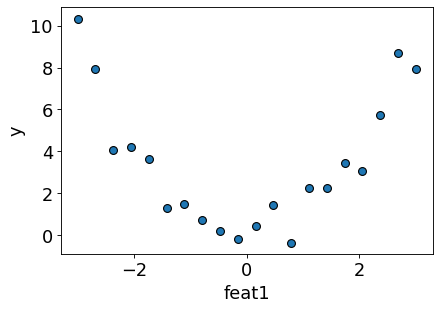

In [3]:
figure(figsize=(6, 4), dpi=80)
plt.scatter(X_toy[:, 0], y_toy, s=50, edgecolors=(0, 0, 0))
plt.xlabel("feat1")
plt.ylabel("y");

- Can simple linear regression fit this data? 
- Let's try it out. 
    - Right now we are focussing on creating a better fit on the training data. So we are skipping splitting the data for the demonstration purpose. 
    - Also, for simplicity, we are using `LinearRegression`, which doesn't have any hyperparameter controlling the complexity of the model. 

In [4]:
# Fit a regression line.
lr = LinearRegression()
lr.fit(X_toy, y_toy)

LinearRegression()

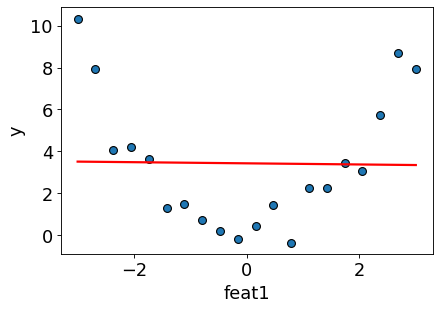

In [5]:
figure(figsize=(6, 4), dpi=80)
plt.scatter(X_toy[:, 0], y, s=50, edgecolors=(0, 0, 0))
preds = lr.predict(X_toy)
plt.xlabel("feat1")
plt.ylabel("y")
plt.plot(X_toy, preds, color="red", linewidth=2);

- As expected, the regression line is unable to capture the shape of the data. 
- The model is underfit. 
- The score on the training data is close to a dummy model. 

In [6]:
lr.score(X_toy, y_toy)

0.0002572570295679144

In [7]:
DummyRegressor().fit(X_toy, y_toy).score(X_toy, y_toy)

0.0

### Adding quadratic features

- It looks like a quadratic function would be more suitable for this dataset. 
- A linear model on its own cannot fit a quadratic function. But what if we **augment the data with a new quadratic feature**? 
- Let's try it out. 

In [8]:
# add a squared feature
X_sq = np.hstack([X_toy, X_toy**2])
pd.DataFrame(X_sq, columns=["feat1", "feat1^2"])

,feat1,feat1^2
0,-3.000000,9.000000
1,-2.684211,7.204986
2,-2.368421,5.609418
3,-2.052632,4.213296
4,-1.736842,3.016620
5,-1.421053,2.019391
6,-1.105263,1.221607
7,-0.789474,0.623269
8,-0.473684,0.224377
9,-0.157895,0.024931


Let's plot our augmented data along with `y`. 

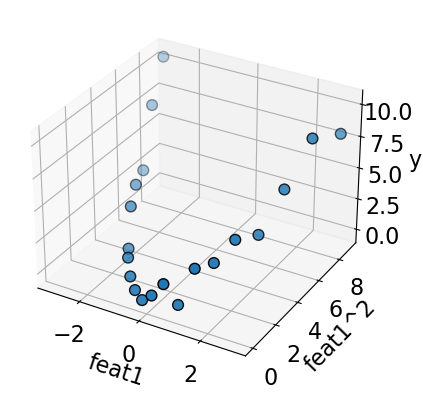

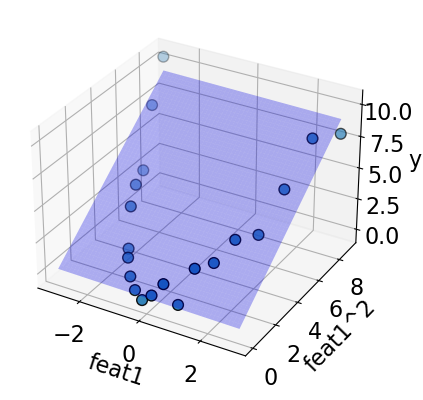

In [9]:
plot_3d_reg(X_sq, y)  # user-defined function from plotting_functions.py
plot_3d_reg(X_sq, y, surface=True)

- A linear model fits well on this augmented data now!!
- This is a common way to make linear models more flexible by adding more degrees of freedom. 
- The model is still linear, i.e., it's still learning the coefficients for each feature. But the feature space is augmented now.   

In [10]:
lr = LinearRegression()
lr.fit(X_sq, y_toy)  # Linear regression with augmented data
lr.score(X_sq, y_toy)  # The scores are much better now

0.9270602202765702

In [11]:
pd.DataFrame(
    lr.coef_.transpose(), index=["feat1", "feat1^2"], columns=["Feature coefficient"]
)

,Feature coefficient
feat1,-0.027196
feat1^2,1.006051


- According to the model, our newly created feat1^2 feature is the most important feature for prediction; the coefficient of the squared feature has the biggest magnitude.
- The idea of transforming features and creating new features is referred to as **change of basis**. 

### Polynomial regression in `sklearn`

- In `sklearn` we can add polynomial features using [sklearn's PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- Using this we can generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to a specified degree. 
- `PolynomialFeatures` is a transformer. 
- For one-dimensional feature vector `[a]`, the augmented features with degree 2 polynomial would be: $[1, a, a^2]$. 
- For two-dimensional feature vector `[a, b]`, the augmented features with degree 2 polynomial would be: $[1, a, b, a^2, ab, b^2]$.

Let's try polynomial features with degree 2 and visualize augmented features. 

In [12]:
from sklearn.preprocessing import PolynomialFeatures

deg = 2
poly_feats = PolynomialFeatures(degree=deg)
X_enc = poly_feats.fit_transform(X_toy)
pd.DataFrame(X_enc, columns=poly_feats.get_feature_names_out()).head()

,1,x0,x0^2
0,1.0,-3.000000,9.000000
1,1.0,-2.684211,7.204986
2,1.0,-2.368421,5.609418
3,1.0,-2.052632,4.213296
4,1.0,-1.736842,3.016620


- Let's fit linear regression on the transformed data. 

In [13]:
lr_poly = LinearRegression()
lr_poly.fit(X_enc, y_toy)
preds = lr_poly.predict(X_enc)
lr_poly.score(X_enc, y_toy)

0.9270602202765702

- The model is not underfit anymore. The training score is pretty good! 
- Let's examine the coefficients.

We can also plot the prediction from the augmented 3-D space in the original 2-D space. 

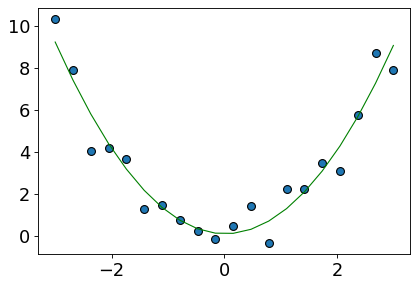

In [14]:
figure(figsize=(6, 4), dpi=80)
plt.scatter(X_toy[:, 0], y_toy, s=50, edgecolors=(0, 0, 0))
plt.plot(X, preds, color="green", linewidth=1);

- Now the fit is much better compared to linear regression on the original data! 
- What's happening here? 
- The actual linear regression model is fit in the augmented space and making the prediction in that augmented space.  

Let's try degree=20 polynomial.

In [15]:
deg = 20
poly_feats = PolynomialFeatures(degree=deg)
X_enc = poly_feats.fit_transform(X_toy)
pd.DataFrame(X_enc, columns=poly_feats.get_feature_names_out()).head(10)

,1,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,...,x0^11,x0^12,x0^13,x0^14,x0^15,x0^16,x0^17,x0^18,x0^19,x0^20
0,1.0,-3.000000,9.000000,-27.000000,81.000000,-243.000000,729.000000,-2187.000000,6.561000e+03,-1.968300e+04,...,-1.771470e+05,5.314410e+05,-1.594323e+06,4.782969e+06,-1.434891e+07,4.304672e+07,-1.291402e+08,3.874205e+08,-1.162261e+09,3.486784e+09
1,1.0,-2.684211,7.204986,-19.339700,51.911825,-139.342268,374.023983,-1003.959113,2.694838e+03,-7.233512e+03,...,-5.211735e+04,1.398939e+05,-3.755048e+05,1.007934e+06,-2.705507e+06,7.262150e+06,-1.949314e+07,5.232369e+07,-1.404478e+08,3.769915e+08
2,1.0,-2.368421,5.609418,-13.285464,31.465573,-74.523727,176.503563,-418.034755,9.900823e+02,-2.344932e+03,...,-1.315370e+04,3.115351e+04,-7.378462e+04,1.747531e+05,-4.138888e+05,9.802630e+05,-2.321675e+06,5.498705e+06,-1.302325e+07,3.084454e+07
3,1.0,-2.052632,4.213296,-8.648345,17.751867,-36.438042,74.793875,-153.524271,3.151288e+02,-6.468433e+02,...,-2.725342e+03,5.594124e+03,-1.148268e+04,2.356970e+04,-4.837991e+04,9.930614e+04,-2.038389e+05,4.184062e+05,-8.588338e+05,1.762869e+06
4,1.0,-1.736842,3.016620,-5.239393,9.099999,-15.805262,27.451244,-47.678477,8.280999e+01,-1.438279e+02,...,-4.338741e+02,7.535708e+02,-1.308834e+03,2.273237e+03,-3.948254e+03,6.857494e+03,-1.191038e+04,2.068646e+04,-3.592911e+04,6.240319e+04
5,1.0,-1.421053,2.019391,-2.869660,4.077938,-5.794965,8.234950,-11.702298,1.662958e+01,-2.363151e+01,...,-4.772125e+01,6.781441e+01,-9.636784e+01,1.369438e+02,-1.946043e+02,2.765430e+02,-3.929821e+02,5.584483e+02,-7.935844e+02,1.127725e+03
6,1.0,-1.105263,1.221607,-1.350197,1.492323,-1.649409,1.823031,-2.014930,2.227027e+00,-2.461451e+00,...,-3.006925e+00,3.323444e+00,-3.673280e+00,4.059941e+00,-4.487303e+00,4.959651e+00,-5.481719e+00,6.058742e+00,-6.696505e+00,7.401400e+00
7,1.0,-0.789474,0.623269,-0.492054,0.388464,-0.306682,0.242117,-0.191145,1.509042e-01,-1.191349e-01,...,-7.425304e-02,5.862082e-02,-4.627960e-02,3.653652e-02,-2.884462e-02,2.277207e-02,-1.797795e-02,1.419312e-02,-1.120509e-02,8.846127e-03
8,1.0,-0.473684,0.224377,-0.106284,0.050345,-0.023848,0.011296,-0.005351,2.534611e-03,-1.200605e-03,...,-2.693878e-04,1.276048e-04,-6.044436e-05,2.863154e-05,-1.356231e-05,6.424252e-06,-3.043067e-06,1.441453e-06,-6.827933e-07,3.234284e-07
9,1.0,-0.157895,0.024931,-0.003936,0.000622,-0.000098,0.000015,-0.000002,3.863147e-07,-6.099706e-08,...,-1.520702e-09,2.401109e-10,-3.791224e-11,5.986144e-12,-9.451806e-13,1.492390e-13,-2.356406e-14,3.720641e-15,-5.874696e-16,9.275836e-17


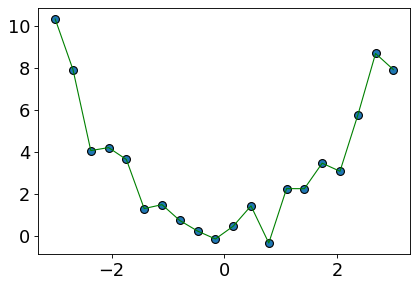

In [16]:
lr_poly = LinearRegression()
lr_poly.fit(X_enc, y)
preds = lr_poly.predict(X_enc)
figure(figsize=(6, 4), dpi=80)
plt.scatter(X_toy[:, 0], y_toy, s=50, edgecolors=(0, 0, 0))
plt.plot(X_toy, preds, color="green", linewidth=1);

- It seems like we are overfitting now. 
- The model is trying to go through every training point. 
- The model is likely to overfit on unseen data.  
- You can pick the degree of polynomial using hyperparameter optimization. 

### Interim summary 

- We can make linear models more flexible by augmenting the feature space. 
- One way to do it is by applying polynomial transformations.  
- Example: Suppose $X$ has only one feature, say $f_1$$

$$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$

- We can add a new feature $f_1^2$? 

- Our $Z$ will have three features $f_0$, $f_1$, $f_1^2$ with polynomial with degree 2. 
$$Z = \begin{bmatrix}1 & 0.86 & 0.74\\ 1 & 0.02 & 0.0004\\ 1 & -0.42 & 0.18\\ \end{bmatrix}$$

<br> 

- $Z$ $\rightarrow$ augmented dataset with quadratic features
- `fit`: We fit using $Z$ and learn weights $v$. 
- `predict`: When we predict, we need to apply the same transformations on the test example and add these features in the test example and predict using learned weights $v$.

**$\hat{y}$ is still a linear function of $v$ and $Z$.**



### `PolynomialFeatures` with sklearn pipelines

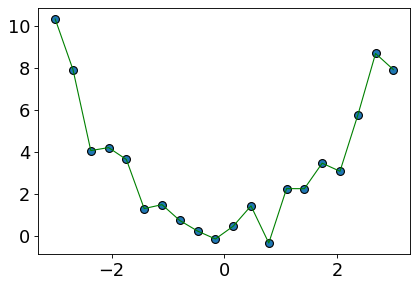

In [17]:
degree = 20
pipe_poly = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

pipe_poly.fit(X_toy, y_toy)
preds = pipe_poly.predict(X_toy)
figure(figsize=(6, 4), dpi=80)
plt.scatter(X_toy[:, 0], y_toy, s=50, edgecolors=(0, 0, 0))
plt.plot(X, preds, color="green", linewidth=1);

The model has learned coefficients for the transformed features. 

In [18]:
pd.DataFrame(
    pipe_poly.named_steps["linearregression"].coef_.transpose(),
    index=pipe_poly.named_steps["polynomialfeatures"].get_feature_names_out(),
    columns=["Feature coefficients"],
).sort_values("Feature coefficients", ascending=False)

,Feature coefficients
x0^7,84.271533
x0^11,31.398818
x0^6,29.056499
x0^12,16.435514
x0^2,9.626527
x0^8,8.711761
x0^3,3.763840
x0,1.856515
x0^15,1.138977
x0^16,0.755986


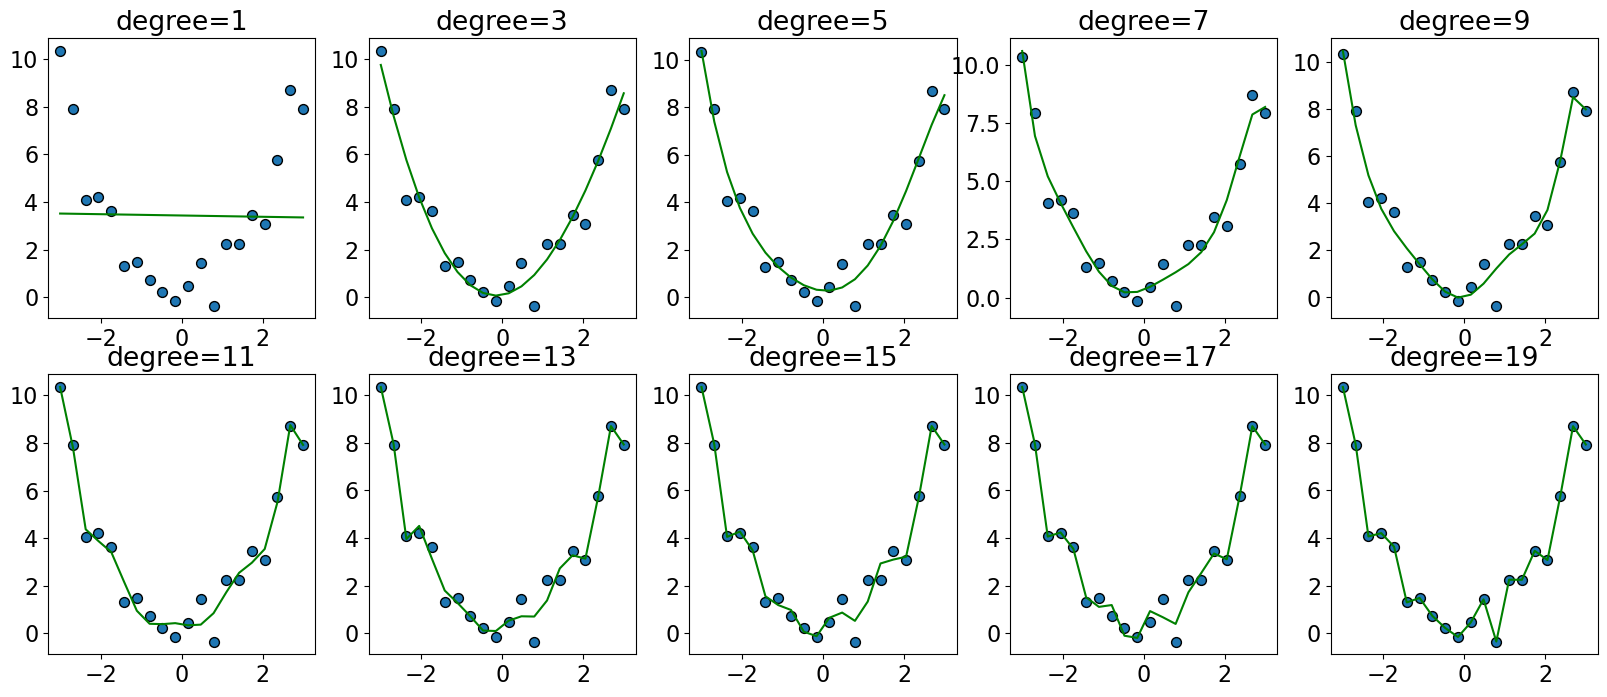

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

degrees = np.arange(1, 20, 2)

for deg, ax in zip(degrees, axes.ravel()):
    pipe_poly = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    pipe_poly.fit(X_toy, y_toy)
    preds = pipe_poly.predict(X_toy)
    ax.scatter(X_toy[:, 0], y_toy, s=50, edgecolors=(0, 0, 0))
    ax.plot(X_toy, preds, color="green", linewidth=1.5)
    title = "degree={}".format(deg)
    ax.set_title(title)

<br><br>

### Classification setting: Non-linearly separable data 

Let's consider this non-linearly separable 1-D data. 

Text(0.5, 0, 'Feature0')

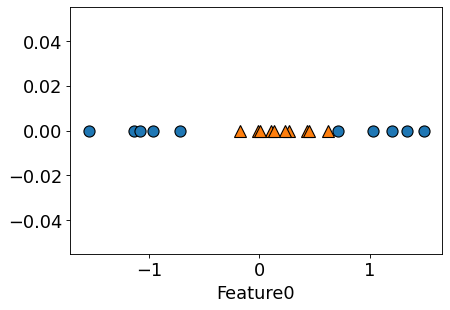

In [20]:
# Consider this one-dimensional classification dataset
n = 20
d = 1
np.random.seed(10)
X = np.random.randn(n, d)
y = np.sum(X**2, axis=1) < 0.4
figure(figsize=(6, 4), dpi=80)
# plt.scatter(X[:, 0], np.zeros_like(X), c=y, s=50, edgecolors=(0, 0, 0));
mglearn.discrete_scatter(X[:, 0], np.zeros_like(X), y)
plt.xlabel("Feature0")
# plt.legend();

Can we use a linear classifier on this dataset? 

In [21]:
linear_svm = SVC(kernel="linear", C=100)
linear_svm.fit(X, y)
print("Training accuracy", linear_svm.score(X, y))

Training accuracy 0.75


What if we augmented this data with polynomial with degree=2 feature? 

In [22]:
X[:5]

array([[ 1.3315865 ],
       [ 0.71527897],
       [-1.54540029],
       [-0.00838385],
       [ 0.62133597]])

In [23]:
poly = PolynomialFeatures(
    2, include_bias=False
)  # Excluding the bias term for simplicity
X_transformed = poly.fit_transform(X)
X_transformed[0:5]

array([[ 1.33158650e+00,  1.77312262e+00],
       [ 7.15278974e-01,  5.11624011e-01],
       [-1.54540029e+00,  2.38826206e+00],
       [-8.38384993e-03,  7.02889396e-05],
       [ 6.21335974e-01,  3.86058392e-01]])

Training accuracy 1.0


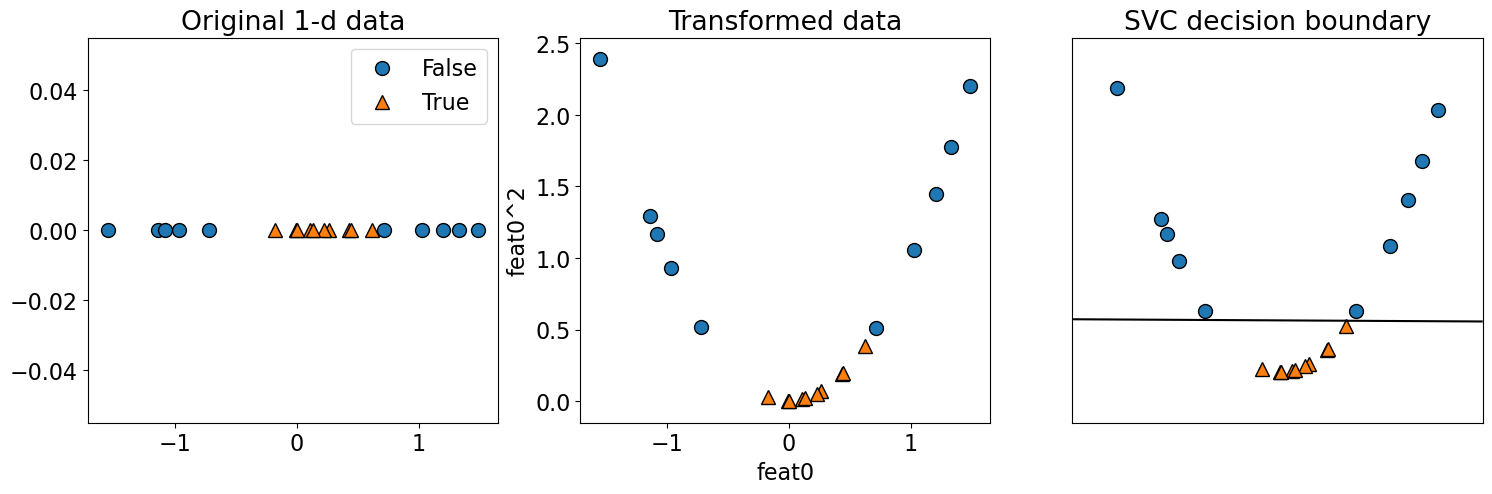

In [24]:
linear_svm = SVC(kernel="linear", C=100)
linear_svm.fit(X_transformed, y)
print("Training accuracy", linear_svm.score(X_transformed, y))
plot_orig_transformed_svc(linear_svm, X, X_transformed, y)

The data is linearly separable in this new feature space!! 

### (Optional) Another example with two features

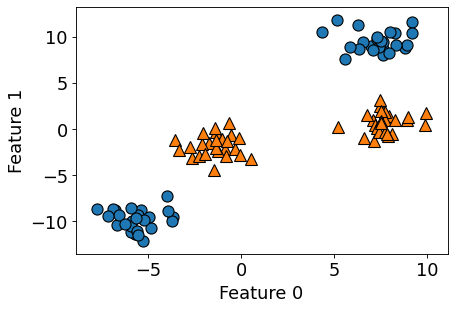

In [25]:
import mglearn
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

figure(figsize=(6, 4), dpi=80)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


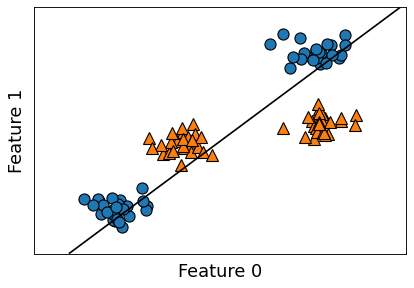

In [26]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(X, y)
figure(figsize=(6, 4), dpi=80)
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

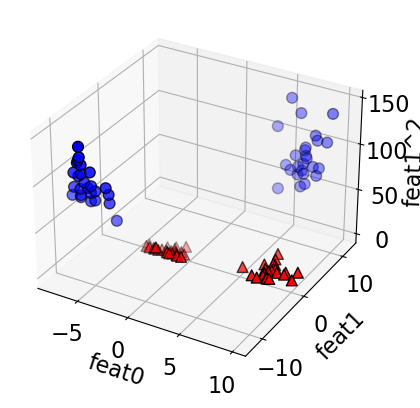

In [27]:
# add square of the second feature
X_new = np.hstack([X, X[:, 1:] ** 2])
plot_mglearn_3d(X_new, y);

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


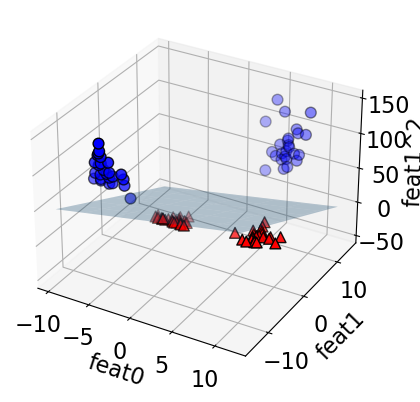

In [28]:
linear_svm_3d = LinearSVC().fit(X_new, y)
XX, YY = plot_svc_3d_decision_boundary(X_new, y, linear_svm_3d)

What does this linear boundary in $Z$-space correspond to _in the original ($X$) space_?

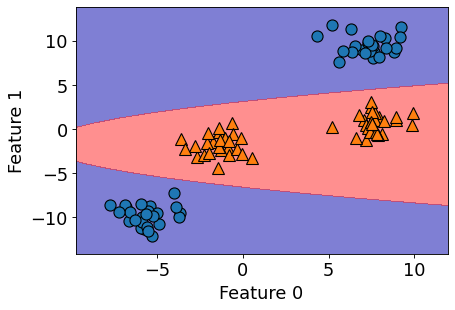

In [29]:
figure(figsize=(6, 4), dpi=80)
plot_Z_space_boundary_in_X_space(linear_svm_3d, X, y, XX, YY)

It's a parabola!

Another example with non-linearly separable data

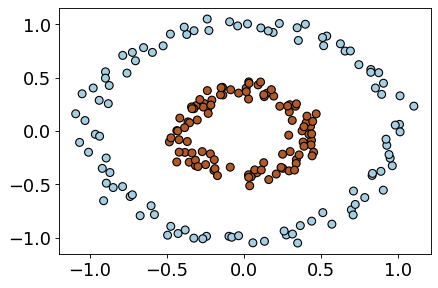

In [30]:
from sklearn import datasets

figure(figsize=(6, 4), dpi=80)
X, y = datasets.make_circles(n_samples=200, noise=0.06, factor=0.4)
plt.scatter(X[:, 0], X[:, 1], s=50, c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0));

In [31]:
lr_circ = LinearRegression()
lr_circ.fit(X, y).score(X, y)

0.00015933776258525434

In [32]:
lr_circ_pipe = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
lr_circ_pipe.fit(X, y).score(X, y)

0.9669328201796121

<br><br>

### Feature interactions and feature crosses

- A **feature cross** is a synthetic feature formed by multiplying or crossing two or more features. 
- Example: 
Is the following dataset (XOR function) linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 1 | 1  | 0|
| -1 | 1  | 1|
| 1 | -1  | 1|
| -1 | -1  | 0|    

- For XOR like problems, if we create a feature cross $x1x2$, the data becomes linearly separable. 

| $$x_1$$ | $$x_2$$ | $$x_1x_2$$ | target|
|---------|---------|---------|---------|
| 1 | 1  | 1 | 0|
| -1 | 1  | -1 | 1|
| 1 | -1  | -1 | 1|
| -1 | -1  | 1 | 0|    

Let's look at an example with more data points. 

In [33]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X_xor = rng.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)

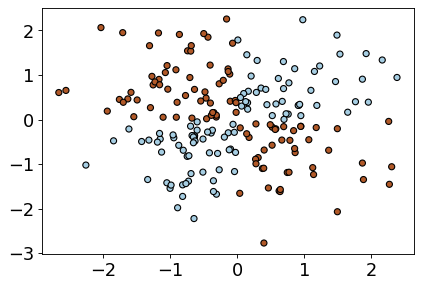

In [34]:
figure(figsize=(6, 4), dpi=80)
plt.scatter(
    X_xor[:, 0], X_xor[:, 1], s=30, c=y_xor, cmap=plt.cm.Paired, edgecolors=(0, 0, 0)
);

In [35]:
LogisticRegression().fit(X_xor, y_xor).score(X_xor, y_xor)

0.535

In [36]:
pipe_xor = make_pipeline(
    PolynomialFeatures(interaction_only=True), LogisticRegression()
)
pipe_xor.fit(X_xor, y_xor)
pipe_xor.score(X_xor, y_xor)

0.995

In [37]:
feature_names = (
    pipe_xor.named_steps["polynomialfeatures"].get_feature_names_out().tolist()
)

In [38]:
pd.DataFrame(
    pipe_xor.named_steps["logisticregression"].coef_.transpose(),
    index=feature_names,
    columns=["Feature coefficient"],
)

,Feature coefficient
1,-0.001828
x0,-0.028418
x1,0.130472
x0 x1,-5.085936


The interaction feature has the biggest coefficient! 

### Feature crosses for one-hot encoded features
- You can think of feature crosses of one-hot-features as logical conjunctions
- Suppose you want to predict whether you will find parking or not based on two features: 
    - area (possible categories: UBC campus and Rogers Arena)
    - time of the day (possible categories: 9am and 7pm)
- A feature cross in this case would create four new features: 
    - UBC campus and 9am
    - UBC campus and 7pm
    - Rogers Arena and 9am
    - Rogers Arena and 7pm. 
- The features UBC campus and 9am on their own are not that informative but the newly created feature UBC campus and 9am or Rogers Arena and 7pm would be quite informative.

- Coming up with the right combination of features requires some domain knowledge or careful examination of the data. 
- There is no easy way to support feature crosses in sklearn. 

### Questions to consider

How do we know what degree of polynomial to use?
- Can we plot data and see how does it look like so that we can pick polynomial with the appropriate degree?
    - Plotting cannot take us much further
    - Not possible to visualize high dimensional data
- Can we consider one feature at a time?  
    - Hopeless when features interact with each other
    - There is a possibility to draw misleading conclusions when you are only looking at one feature at a time.
- Hyperparameter optimization
    - Can be potentially very slow. 


### Problems with polynomial basis 

- Let $d$ be the original number of features and $p$ be the degree of polynomial. 
- In general, we have roughly $\mathcal{O}(d^p)$ feature combinations. 
    - For example, for $d = 1000$, and $p = 3$, we would have around a billion new feature combinations! 
- This is problematic! 

### How can we do this efficiently? 

- Kernel trick 
    - Computationally efficient approach to map features
    - Calculate these relationships in higher dimensional space without actually carrying out the transformation.    
    - Overall, saying something is a "kernel method" correspond to this idea of implicitly calculating relationships in data in higher dimensional space.  
    - Then the different transformations have different names like "polynomial kernel" or "RBF kernel"
    - For details see [this video](https://www.youtube.com/watch?v=mba4xweShwI) from CPSC 340. 
- More on RBF kernel later.     

<br><br><br><br>

## (Optional) Recall RBF Kernel

- Hard to visualize but you can think of this as a weighted nearest-neighbour.
- During prediction, the closest examples have a lot of influence on how we classify the new example compared to the ones further away.
- In general, for both regression/classification, you can think of RBF kernel as "smooth KNN".
- During test time, each training example gets to "vote" on the label of the test point and the amount of vote the $n^{th}$ training example gets is proportional to the the distance between the test point and itself.  

### RBFs

- What is a radial basis function (RBF)?
    - A set of non-parametric bases that depend on distances to training points.
    - Non-parametric because size of basis (number of features) grows with $n$.
- Model gets more complicated as you get more data.

### Example: RBFs 

- Similar to polynomial basis, we transform $X$ to $Z$.
- Consider $X_{train}$ with three examples: $x_1$, $x_2$, and $x_3$ and 2 features sand $X_{test}$ with two examples: $\tilde{x_1}$ and $\tilde{x_2}$

$$\text{Transform } X_{train} = \begin{bmatrix} 1 & 0\\ 2 & 1\\ 1 & 2\end{bmatrix} \text{ to } Z_{train} = \begin{bmatrix} g\lVert x_1 - x_1\rVert & g\lVert x_1 - x_2\rVert & g\lVert x_1 - x_3\rVert\\g\lVert x_2 - x_1\rVert & g\lVert x_2 - x_2\rVert & g\lVert x_2 - x_3\rVert\\g\lVert x_3 - x_1\rVert & g\lVert x_3 - x_2\rVert & g\lVert x_3 - x_3\rVert\end{bmatrix}$$  

$$\text{Transform } X_{test} = \begin{bmatrix} 2 & 1\\ 1 & 1 \end{bmatrix} \text{ to } Z_{test} = \begin{bmatrix} g\lVert \tilde{x_1} - x_1\rVert & g\lVert \tilde{x_1} - x_2\rVert & g\lVert \tilde{x_1} - x_3\rVert\\g\lVert \tilde{x_2} - x_1\rVert & g\lVert \tilde{x_2} - x_2\rVert & g\lVert \tilde{x_2} - x_3\rVert\\\end{bmatrix}$$  

- We create $n$ features. 

### Gaussian Radial Basis Functions (Gaussian RBFs)

- Most common $g$ is Gaussian RBF: $$g(\varepsilon)=\exp\left(-\frac{\varepsilon^2}{2\sigma^2}\right)$$

![](img/RBF.png)

<!-- <center> -->

<!-- <img src='img/RBF.png' width="700" height="700" />     -->

<!-- </center> -->
    
[Source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L13.pdf)

- So in our case: 
$$g(x_i - x_j)=\exp\left(-\frac{\lVert x_i - x_j\rVert^2}{2\sigma^2}\right)$$
- $\sigma$ is a hyperparameter that controls the width of the bumps. 
- We can fit least squares with different $\sigma$ values


#### Gaussian RBFs (non-parametric basis)

![](img/Gaussian_RBF.png)

<!-- <img src='img/Gaussian_RBF.png' width="700" height="700" /> -->

[source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L13.pdf)

- How many bumps should we use?
    - We use $n$ bumps (non-parametric basis)
- Where should the bumps be centered?
    - Each bump is centered on one training example $x_i$. 
- How high should the bumps go?
    - Fitting regression weights $w$ gives us the heights (and signs).
- How wide should the bumps be?
    - The width is a hyper-parameter (narrow bumps = complicated model)

![](img/Gaussian_RBF.png)

<!-- <center> -->
<!-- <img src='img/Gaussian_RBF.png' width="700" height="700" /> -->
<!-- </center> -->
    
[source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L13.pdf)

- Enough bumps can approximate any continuous function to arbitrary precision.
- But with $n$ data points RBFs have $n$ features
    - How do we avoid overfitting with this huge number of features?
    - We regularize $w$ (coming up in two weeks) and use validation error to choose $\sigma$ and $\lambda$.

### Interpretation of `gamma` in SVM RBF

- `gamma` controls the complexity (fundamental trade-off). 
  - larger `gamma` $\rightarrow$ more complex
  - smaller `gamma` $\rightarrow$ less complex
- The `gamma` hyperparameter in SVC is related to $\sigma$ in Gaussian RBF.  
- You can think of `gamma` as the inverse width of the "bumps" 
    - Larger `gamma` means narrower peaks. 
    - Narrower peaks means more complex model. 
    
    
$$g(x_i - x_j)=\exp\left(-\frac{\lVert x_i - x_j\rVert^2}{2\sigma^2}\right)$$    

### Constructing Gaussian RBF with $X$ and $\sigma$

```
Z = zeros(n,n)
for i1 in 1:n
    for i2 in 1:n
        Z(i1,i2) = exp(-(norm(X[i1:] - X[i2:])**2)/(2 * sigma**2)
```

### Gaussian RBFs: Prediction 

- Given a test example $\tilde{x_i}$: 
    
   $$\hat{y_i} = w_1 \exp\left(\frac{-\lVert \tilde{x_i} - x_1\rVert^2}{2\sigma^2}\right) +  w_2 \exp\left(\frac{-\lVert \tilde{x_i} - x_2\rVert^2}{2\sigma^2}\right) + \dots + w_n \exp\left(\frac{-\lVert \tilde{x_i} - x_n\rVert^2}{2\sigma^2}\right)
    = \sum_{j = 1}^n w_j \exp\left(\frac{-\lVert \tilde{x_i} - x_j\rVert^2}{2\sigma^2}\right) $$

- Expensive at test time: needs distance to all training examples.   

### RBF with regulariation and optimized $sigma$ and $\lambda$

- A model that is hard to beat:
    - RBF basis with L2-regularization and cross-validation to choose $\sigma$ and $\lambda$.
    - Flexible non-parametric basis, magic of regularization, and tuning for test error
- For each value of $\lambda$ and $sigma$ 
    - Compute $Z$ on training data
    - Compute best weights $V$ using least squares 
    - Compute $\tilde{Z}$ on validation set (using train set distances)
    - Make predictions $\hat{y} = \tilde{Z}v$
    - Compute validation error 

#### Using RBF with least squares: [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) (optional)
> sklearn.kernel_ridge.KernelRidge(alpha=1, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None)

> Kernel ridge regression.
Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

> The form of the model learned by KRR is identical to support vector regression (SVR). However, different loss functions are used: KRR uses squared error loss while support vector regression uses epsilon-insensitive loss, both combined with l2 regularization. In contrast to SVR, fitting a KRR model can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR, which learns a sparse model for epsilon > 0, at prediction-time.

<br><br><br><br>

### ❓❓ Questions for you

### iClicker Exercise 3.2

**iClicker cloud join link: https://join.iclicker.com/C0P55**

**Select all of the following statements which are TRUE.**

- (A) Suppose we add quadratic features to dataset $X$ and the augmented dataset is $Z$. Fitting linear regression on $Z$ would learn a linear function of $Z$.
- (B) The least squares loss function shown below is independent of the bias term (the $y$ intercept).

$$ J(w) = \sum_{i=1}^{n}{(w^Tx_i - y_i)^2}$$

- (C) If you get the same validation error with polynomials of degrees $d$ and $d+4$, it is a better to pick the polynomial of degree $d$.
- (D) If you are given a large dataset with 1000 features, it's a good idea to start simple and work with one or two features in order to verify your intuitions. 
- (E) Suppose you apply polynomial transformations with degree 3 polynomial during training. During prediction time on the test set, you must calculate degree three polynomial features of the given feature vector in order to get predictions. 

**V's answers: (A), (C), (D), (E)**

<br><br><br><br>

## Break (5 min)

![](img/eva-coffee.png)

<br><br>

### Demo of feature engineering with numeric features

- Remember the [California housing dataset](https://www.kaggle.com/datasets/camnugent/california-housing-prices) we used in DSCI 571? 
- The prediction task is predicting `median_house_value` for a given property. 

In [39]:
housing_df = pd.read_csv("data/california_housing.csv")
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [40]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Suppose we decide to train `ridge` model on this dataset. 

- What would happen if you train a model without applying any transformation on the categorical features ocean_proximity? 
    - Error!! A linear model requires all features in a numeric form.  
- What would happen if we apply OHE on `ocean_proximity` but we do not scale the features?
    - No syntax error. But the model results are likely to be poor. 
- Do we need to apply any other transformations on this data?     

In this section, we will look into some common ways to do feature engineering for numeric or categorical features.  

In [41]:
train_df, test_df = train_test_split(housing_df, test_size=0.2, random_state=123)

We have total rooms and the number of households in the neighbourhood. How about creating rooms_per_household feature using this information? 

In [42]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

In [43]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household
9950,-122.33,38.38,28.0,1020.0,169.0,504.0,164.0,4.5694,287500.0,INLAND,6.219512
3547,-118.60,34.26,18.0,6154.0,1070.0,3010.0,1034.0,5.6392,271500.0,<1H OCEAN,5.951644
4448,-118.21,34.07,47.0,1346.0,383.0,1452.0,371.0,1.7292,191700.0,<1H OCEAN,3.628032
6984,-118.02,33.96,36.0,2071.0,398.0,988.0,404.0,4.6226,219700.0,<1H OCEAN,5.126238
4432,-118.20,34.08,49.0,1320.0,309.0,1405.0,328.0,2.4375,114000.0,<1H OCEAN,4.024390
...,...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,167600.0,<1H OCEAN,5.584615
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,180900.0,<1H OCEAN,6.016688
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,286200.0,<1H OCEAN,5.958393
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY,4.739264


Let's start simple. Imagine that we only three features: `longitude`, `latitude`, and our newly created `rooms_per_household` feature. 

In [44]:
X_train_housing = train_df[["latitude", "longitude", "rooms_per_household"]]
y_train_housing = train_df["median_house_value"]

In [45]:
from sklearn.compose import make_column_transformer

numeric_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor1 = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats)
)

In [46]:
lr_1 = make_pipeline(preprocessor1, Ridge())
pd.DataFrame(
    cross_validate(lr_1, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.005102,0.001189,0.280028,0.311769
1,0.002480,0.000848,0.325319,0.300464
2,0.002208,0.000880,0.317277,0.301952
3,0.002187,0.000890,0.316798,0.303004
4,0.002228,0.000933,0.260258,0.314840


- The scores are not great. 
- Let's look at the distribution of the longitude and latitude features. 

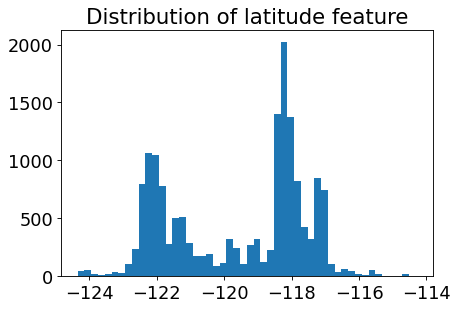

In [47]:
figure(figsize=(6, 4), dpi=80)
plt.hist(train_df["longitude"], bins=50)
plt.title("Distribution of latitude feature");

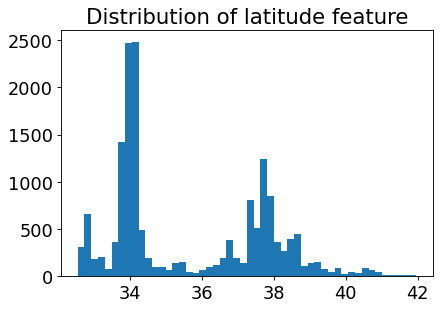

In [48]:
figure(figsize=(6, 4), dpi=80)
plt.hist(train_df["latitude"], bins=50)
plt.title("Distribution of latitude feature");

- Suppose you are planning to build a linear model for housing price prediction. 
- If we think longitude is a good feature for prediction, does it makes sense to use the floating point representation of this feature that's given to us?
- Remember that linear models can capture only linear relationships. 

- How about discretizing latitude and longitude features and putting them into buckets?
- This process of transforming numeric features into categorical features is called bucketing or binning. 
- In `sklearn` you can do this using `KBinsDiscretizer` transformer. 
- Let's examine whether we get better results with binning.

In [49]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude"]
numeric_feats = ["rooms_per_household"]

preprocessor2 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats),
)

In [50]:
lr_2 = make_pipeline(preprocessor2, Ridge())
pd.DataFrame(
    cross_validate(lr_2, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.015637,0.002666,0.441442,0.456418
1,0.010789,0.002345,0.469554,0.446215
2,0.010230,0.002478,0.479166,0.446868
3,0.009855,0.002336,0.450818,0.453366
4,0.009889,0.002189,0.388175,0.467627


The results are better with binned features. Let's examine how do these binned features look like. 

In [51]:
lr_2.fit(X_train_housing, y_train_housing)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=20),
                                                  ['latitude', 'longitude']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['rooms_per_household'])])),
                ('ridge', Ridge())])

In [52]:
pd.DataFrame(
    preprocessor2.fit_transform(X_train_housing).todense(),
    columns=preprocessor2.get_feature_names_out(),
)

,kbinsdiscretizer__latitude_0.0,kbinsdiscretizer__latitude_1.0,kbinsdiscretizer__latitude_2.0,kbinsdiscretizer__latitude_3.0,kbinsdiscretizer__latitude_4.0,kbinsdiscretizer__latitude_5.0,kbinsdiscretizer__latitude_6.0,kbinsdiscretizer__latitude_7.0,kbinsdiscretizer__latitude_8.0,kbinsdiscretizer__latitude_9.0,...,kbinsdiscretizer__longitude_11.0,kbinsdiscretizer__longitude_12.0,kbinsdiscretizer__longitude_13.0,kbinsdiscretizer__longitude_14.0,kbinsdiscretizer__longitude_15.0,kbinsdiscretizer__longitude_16.0,kbinsdiscretizer__longitude_17.0,kbinsdiscretizer__longitude_18.0,kbinsdiscretizer__longitude_19.0,pipeline__rooms_per_household
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316164
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209903
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711852
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.117528
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.554621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.064307
16508,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.235706
16509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212581
16510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.271037


How about discretizing all three features? 

In [53]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor3 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
)

In [54]:
lr_3 = make_pipeline(preprocessor3, Ridge())
pd.DataFrame(
    cross_validate(lr_3, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.010873,0.002158,0.590610,0.571969
1,0.010465,0.002116,0.575886,0.570473
2,0.011467,0.002253,0.579108,0.573541
3,0.010105,0.001971,0.571495,0.574259
4,0.010333,0.002268,0.541501,0.581687


- The results have improved further!! 
- Let's examine the coefficients

In [55]:
lr_3.fit(X_train_housing, y_train_housing)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=20),
                                                  ['latitude', 'longitude',
                                                   'rooms_per_household'])])),
                ('ridge', Ridge())])

In [56]:
feature_names = (
    lr_3.named_steps["columntransformer"]
    .named_transformers_["kbinsdiscretizer"]
    .get_feature_names_out()
)

In [57]:
lr_3.named_steps["ridge"].coef_.shape

(60,)

In [58]:
coefs_df = pd.DataFrame(
    lr_3.named_steps["ridge"].coef_.transpose(),
    index=feature_names,
    columns=["coefficient"],
).sort_values("coefficient", ascending=False)
coefs_df.head

<bound method NDFrame.head of                             coefficient
longitude_1.0             211264.741526
latitude_1.0              205072.700578
latitude_0.0              201872.963204
longitude_0.0             190382.307281
longitude_2.0             160226.705422
longitude_3.0             157170.570627
latitude_2.0              154016.104655
rooms_per_household_19.0  138446.914059
latitude_8.0              135312.891136
longitude_4.0             132299.492558
latitude_7.0              124997.893455
latitude_3.0              118555.428435
longitude_5.0             116178.110119
rooms_per_household_18.0  102055.752443
longitude_6.0              96570.932606
latitude_4.0               92839.285885
latitude_6.0               90957.852350
latitude_9.0               71151.812511
rooms_per_household_17.0   70487.600832
latitude_5.0               69460.010604
longitude_10.0             52387.931534
rooms_per_household_16.0   44318.361075
rooms_per_household_15.0   31461.590554
longitude_

- Does it make sense to take feature crosses in this context?
- What information would they encode? 

<br><br><br><br>

## Feature engineering for text data 

- Feature engineering is very relevant in the context of "structured" data such as text data or image data. 
- We can extract important information using human knowledge and incorporate it into our models. 
- So it's hard to talk about general methods for feature engineering. 
- In the lab you'll be carrying out feature engineering on text data. 
- Let's look at an example of feature engineering for text data. 

We will be using [Covid tweets](https://www.kaggle.com/code/kerneler/starter-covid-19-nlp-text-d3a3baa6-e/data) dataset for this. 

In [59]:
df = pd.read_csv("data/Corona_NLP_test.csv")
df["Sentiment"].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

In [60]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [61]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1927,1928,46880,"Seattle, WA",13-03-2020,"While I don't like all of Amazon's choices, to...",Positive
1068,1069,46021,NaN,13-03-2020,"Me: shit buckets, its time to do the weekly s...",Negative
803,804,45756,The Outer Limits,12-03-2020,@SecPompeo @realDonaldTrump You mean the plan ...,Neutral
2846,2847,47799,"Flagstaff, AZ",15-03-2020,@lauvagrande People who are sick arent panic ...,Extremely Negative
3768,3769,48721,"Montreal, Canada",16-03-2020,Coronavirus Panic: Toilet Paper Is the People...,Negative
...,...,...,...,...,...,...
1122,1123,46075,NaN,13-03-2020,Photos of our local grocery store shelveswher...,Extremely Positive
1346,1347,46299,Toronto,13-03-2020,Just went to the the grocery store (Highland F...,Positive
3454,3455,48407,"Houston, TX",16-03-2020,Real talk though. Am I the only one spending h...,Neutral
3437,3438,48390,"Washington, DC",16-03-2020,The supermarket business is booming! #COVID2019,Neutral


In [62]:
train_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [63]:
train_df["Location"].value_counts()

United States                     63
London, England                   37
Los Angeles, CA                   30
New York, NY                      29
Washington, DC                    29
                                  ..
Suburb of Chicago                  1
philippines                        1
Dont ask for freedom, take it.     1
Windsor Heights, IA                1
St James' Park, Newcastle          1
Name: Location, Length: 1441, dtype: int64

In [64]:
X_train, y_train = train_df[["OriginalTweet"]], train_df["Sentiment"]
X_test, y_test = test_df[["OriginalTweet"]], test_df["Sentiment"]

In [65]:
y_train.value_counts()

Negative              852
Positive              743
Neutral               501
Extremely Negative    472
Extremely Positive    470
Name: Sentiment, dtype: int64

In [66]:
scoring_metrics = "accuracy"

In [67]:
results = {}

In [68]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Dummy classifier

In [69]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),0.280 (+/- 0.001),0.280 (+/- 0.000)


### Bag-of-words model 

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)
results["logistic regression"] = mean_std_cross_val_scores(
    pipe,
    X_train["OriginalTweet"],
    y_train,
    return_train_score=True,
    scoring=scoring_metrics,
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),0.280 (+/- 0.001),0.280 (+/- 0.000)
logistic regression,0.477 (+/- 0.024),0.007 (+/- 0.000),0.413 (+/- 0.011),0.999 (+/- 0.000)


### Is it possible to further improve the scores?

- How about adding new features based on our intuitions? Let's extract our own features that might be useful for this prediction task. In other words, let's carry out **feature engineering**. 

- The code below adds some very basic length-related and sentiment features. We will be using a popular library called `nltk` for this exercise. If you have successfully created the course `conda` environment on your machine, you should already have this package in the environment.  

- How do we extract interesting information from text?
- We use **pre-trained models**! 

- A couple of popular libraries which include such pre-trained models. 
- `nltk`
```
conda install -c anaconda nltk 
```        
- spaCy
```
conda install -c conda-forge spacy
```

For emoji support: 
```
pip install spacymoji
```

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment or here.  

In [71]:
import spacy

# !python -m spacy download en_core_web_md

In [72]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/kvarada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [73]:
nltk.download("vader_lexicon")
nltk.download("punkt")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kvarada/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kvarada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
s = "MDS students are smart, sweet, and funny."
print(sid.polarity_scores(s))

{'neg': 0.0, 'neu': 0.317, 'pos': 0.683, 'compound': 0.8225}


In [75]:
s = "MDS students are tired because of all the hard work they have been doing."
print(sid.polarity_scores(s))

{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5106}


### [spaCy](https://spacy.io/) 

A useful package for text processing and feature extraction
- Active development: https://github.com/explosion/spaCy
- Interactive lessons by Ines Montani: https://course.spacy.io/en/
- Good documentation, easy to use, and customizable. 

In [76]:
import en_core_web_md  # pre-trained model
import spacy

nlp = en_core_web_md.load()

In [77]:
sample_text = """Dolly Parton is a gift to us all. 
From writing all-time great songs like “Jolene” and “I Will Always Love You”, 
to great performances in films like 9 to 5, to helping fund a COVID-19 vaccine, 
she’s given us so much. Now, Netflix bring us Dolly Parton’s Christmas on the Square, 
an original musical that stars Christine Baranski as a Scrooge-like landowner 
who threatens to evict an entire town on Christmas Eve to make room for a new mall. 
Directed and choreographed by the legendary Debbie Allen and counting Jennifer Lewis 
and Parton herself amongst its cast, Christmas on the Square seems like the perfect movie
to save Christmas 2020. 😻 👍🏿"""

# [Adapted from here.](https://thepopbreak.com/2020/11/22/dolly-partons-christmas-on-the-square-review-not-quite-a-christmas-miracle/)

Spacy extracts all interesting information from text with this call.

In [78]:
doc = nlp(sample_text)

Let's look at part-of-speech tags. 

In [79]:
print([(token, token.pos_) for token in doc][:20])

[(Dolly, 'PROPN'), (Parton, 'PROPN'), (is, 'AUX'), (a, 'DET'), (gift, 'NOUN'), (to, 'ADP'), (us, 'PRON'), (all, 'PRON'), (., 'PUNCT'), (
, 'SPACE'), (From, 'ADP'), (writing, 'VERB'), (all, 'DET'), (-, 'PUNCT'), (time, 'NOUN'), (great, 'ADJ'), (songs, 'NOUN'), (like, 'ADP'), (“, 'PUNCT'), (Jolene, 'PROPN')]


- Often we want to know who did what to whom. 
- **Named entities** give you this information.  
- What are named entities in the text? 

In [80]:
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])
print("\nORG means: ", spacy.explain("ORG"))
print("\nPERSON means: ", spacy.explain("PERSON"))
print("\nDATE means: ", spacy.explain("DATE"))

Named entities:
 [('Dolly Parton', 'PERSON'), ('Jolene', 'WORK_OF_ART'), ('I Will Always Love You', 'WORK_OF_ART'), ('9', 'CARDINAL'), ('Netflix', 'ORG'), ('Dolly Parton’s', 'PERSON'), ('Christmas', 'DATE'), ('Square', 'FAC'), ('Christine Baranski', 'PERSON'), ('Christmas Eve', 'DATE'), ('Debbie Allen', 'PERSON'), ('Jennifer Lewis', 'PERSON'), ('Parton', 'PERSON'), ('Christmas', 'DATE'), ('Square', 'FAC'), ('Christmas 2020', 'DATE'), ('😻', 'GPE')]

ORG means:  Companies, agencies, institutions, etc.

PERSON means:  People, including fictional

DATE means:  Absolute or relative dates or periods


In [81]:
from spacy import displacy

displacy.render(doc, style="ent")

###  An example from a project 

Goal: Extract and visualize inter-corporate relationships from disclosed annual 10-K reports of public companies. 

[Source for the text below.](https://www.bbc.com/news/business-39875417)

In [82]:
text = (
    "Heavy hitters, including Microsoft and Google, "
    "are competing for customers in cloud services with the likes of IBM and Salesforce."
)

In [83]:
doc = nlp(text)
displacy.render(doc, style="ent")
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])

Named entities:
 [('Microsoft', 'ORG'), ('Google', 'ORG'), ('IBM', 'ORG'), ('Salesforce', 'PRODUCT')]


If you want emoji identification support install [`spacymoji`](https://pypi.org/project/spacymoji/) in the course environment. 

```
pip install spacymoji
```

After installing `spacymoji`, if it's still complaining about module not found, my guess is that you do not have `pip` installed in your `conda` environment. Go to your course `conda` environment install `pip` and install the `spacymoji` package in the environment using the `pip` you just installed in the current environment. 

```
conda install pip
YOUR_MINICONDA_PATH/miniconda3/envs/cpsc330/bin/pip install spacymoji
```

In [84]:
from spacymoji import Emoji

nlp.add_pipe("emoji", first=True);

Does the text have any emojis? If yes, extract the description. 

In [85]:
doc = nlp(sample_text)
doc._.emoji

[('😻', 138, 'smiling cat face with heart-eyes'),
 ('👍🏿', 139, 'thumbs up dark skin tone')]

<br><br><br><br>

### Simple feature engineering for our problem. 

In [86]:
def get_relative_length(text, TWITTER_ALLOWED_CHARS=280.0):
    """
    Returns the relative length of text.

    Parameters:
    ------
    text: (str)
    the input text

    Keyword arguments:
    ------
    TWITTER_ALLOWED_CHARS: (float)
    the denominator for finding relative length

    Returns:
    -------
    relative length of text: (float)

    """
    return len(text) / TWITTER_ALLOWED_CHARS


def get_length_in_words(text):
    """
    Returns the length of the text in words.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    length of tokenized text: (int)

    """
    return len(nltk.word_tokenize(text))


def get_sentiment(text):
    """
    Returns the compound score representing the sentiment: -1 (most extreme negative) and +1 (most extreme positive)
    The compound score is a normalized score calculated by summing the valence scores of each word in the lexicon.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    sentiment of the text: (str)
    """
    scores = sid.polarity_scores(text)
    return scores["compound"]

In [87]:
train_df = train_df.assign(n_words=train_df["OriginalTweet"].apply(get_length_in_words))
train_df = train_df.assign(
    vader_sentiment=train_df["OriginalTweet"].apply(get_sentiment)
)
train_df = train_df.assign(
    rel_char_len=train_df["OriginalTweet"].apply(get_relative_length)
)

test_df = test_df.assign(n_words=test_df["OriginalTweet"].apply(get_length_in_words))
test_df = test_df.assign(vader_sentiment=test_df["OriginalTweet"].apply(get_sentiment))
test_df = test_df.assign(
    rel_char_len=test_df["OriginalTweet"].apply(get_relative_length)
)

In [88]:
train_df.shape

(3038, 9)

In [89]:
X_train

,OriginalTweet
1927,"While I don't like all of Amazon's choices, to..."
1068,"Me: shit buckets, its time to do the weekly s..."
803,@SecPompeo @realDonaldTrump You mean the plan ...
2846,@lauvagrande People who are sick arent panic ...
3768,Coronavirus Panic: Toilet Paper Is the People...
...,...
1122,Photos of our local grocery store shelveswher...
1346,Just went to the the grocery store (Highland F...
3454,Real talk though. Am I the only one spending h...
3437,The supermarket business is booming! #COVID2019


In [90]:
X_train = train_df.drop(columns=["Sentiment"])

In [91]:
numeric_features = ["vader_sentiment", "rel_char_len", "n_words"]
text_feature = "OriginalTweet"
drop_features = ["UserName", "ScreenName", "Location", "TweetAt"]

In [92]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (CountVectorizer(stop_words="english"), text_feature),
    ("drop", drop_features),
)

In [93]:
pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
results["LR (more feats)"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),0.280 (+/- 0.001),0.280 (+/- 0.000)
logistic regression,0.477 (+/- 0.024),0.007 (+/- 0.000),0.413 (+/- 0.011),0.999 (+/- 0.000)
LR (more feats),0.608 (+/- 0.069),0.010 (+/- 0.001),0.689 (+/- 0.006),0.998 (+/- 0.001)


In [94]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['vader_sentiment',
                                                   'rel_char_len', 'n_words']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'OriginalTweet'),
                                                 ('drop', 'drop',
                                                  ['UserName', 'ScreenName',
                                                   'Location', 'TweetAt'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [95]:
cv_feats = (
    pipe.named_steps["columntransformer"]
    .named_transformers_["countvectorizer"]
    .get_feature_names_out().tolist()
)

In [96]:
feat_names = numeric_features + cv_feats

In [97]:
coefs = pipe.named_steps["logisticregression"].coef_[0]

In [98]:
df = pd.DataFrame(
    data={
        "features": feat_names,
        "coefficients": coefs,
    }
)
df.sort_values("coefficients")

,features,coefficients
0,vader_sentiment,-6.156919
11329,won,-1.386911
2549,coronapocalypse,-0.818268
2212,closed,-0.751250
8659,retail,-0.730537
...,...,...
3297,don,1.146414
9860,stupid,1.159503
4877,hell,1.295756
3127,die,1.364247


We get some improvements with our engineered features! 

<br><br><br><br>

### Common features used in text classification

### Bag of words 

- So far for text data we have been using bag of word features. 
- They are good enough for many tasks. But ... 
- This encoding throws out a lot of things we know about language
- It assumes that word order is not that important.   
- So if you want to improve the scores further on text classification tasks you carry out **feature engineering**. 

Let's look at some examples from research papers.  

### Example: Label "Personalized" Important E-mails: 
- [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf)
- Features: bag of words, trigrams, regular expressions, and so on.
- There might be some "globally" important messages:
    - "This is your mother, something terrible happened, give me a call ASAP."
- But your "important" message may be unimportant to others.
     - Similar for spam: "spam" for one user could be "not spam" for another.

- Social features (e.g., percentage of sender emails that is read by the recipient)
- Content features (e.g., recent terms the user has been using in emails)
- Thread features (e.g., whether the user has started the thread)
- ...

### [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf)

![](img/gmail_priority_inbox.png)

<!-- <img src="img/gmail_priority_inbox.png" width="1000" height="1000"> -->

#### Feature engineering examples: [Automatically Identifying Good Conversations Online](http://www.courtneynapoles.com/res/icwsm17-automatically.pdf)

![](img/classifying_good_conversations_online.png)

<!-- <img src="img/classifying_good_conversations_online.png" width="800" height="800"> -->


### (Optional) Term weighing (TF-IDF) 

- A measure of relatedness between words and documents
- Intuition: Meaningful words may occur repeatedly in related documents, but functional words (e.g., _make_, _the_) may be distributed evenly over all documents


$$tf.idf(w_i,d_j) = (1+log(tf_{ij})) log\frac{D}{df_i}$$


where, 
- $tf_{ij}$ &rarr; number of occurrences of the term $w_i$ in document $d_j$
- $D$ &rarr; number of documents
- $df_i$ &rarr; number of documents in which $w_i$ occurs

Check `TfidfVectorizer` from `sklearn`. 

### N-grams 

- Incorporating more context 
- A contiguous sequence of _n_ items (characters, tokens) in text.
    <blockquote>
        MDS students are hard-working .
    </blockquote>    

- 2-grams (bigrams): a contiguous sequence of two words
    * MDS students, students are, are hard-working, hard-working ._
- 3-grams (trigrams): a contiguous sequence of three words
    * _MDS students are, students are hard-working, are hard-working ._

You can extract ngram features using `CountVectorizer` by passing `ngram_range`. 

In [99]:
from sklearn.feature_extraction.text import CountVectorizer

X = [
    "URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!",
    "Lol you are always so convincing.",
    "URGENT!! Call right away!!",
]
vec = CountVectorizer(ngram_range=(1, 3))
X_counts = vec.fit_transform(X)
bow_df = pd.DataFrame(X_counts.toarray(), columns=vec.get_feature_names(), index=X)

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [100]:
bow_df

,900,900 prize,900 prize reward,always,always so,always so convincing,are,are always,are always so,as,...,urgent call,urgent call right,valued,valued network,valued network customer,you,you are,you are always,you have,you have been
URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!,1,1,1,0,0,0,0,0,0,1,...,0,0,1,1,1,1,0,0,1,1
Lol you are always so convincing.,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,1,0,0
URGENT!! Call right away!!,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


### ASIDE: [Google n-gram viewer](https://books.google.com/ngrams)
 
- All Our N-gram are Belong to You
    - https://ai.googleblog.com/2006/08/all-our-n-gram-are-belong-toyou.html

<blockquote>
Here at Google Research we have been using word n-gram models for a variety
of R&D projects, such as statistical machine translation, speech recognition,
spelling correction, entity detection, information extraction, and others.
That's why we decided to share this enormous dataset with everyone. We
processed 1,024,908,267,229 words of running text and are publishing the
counts for all 1,176,470,663 five-word sequences that appear at least 40
times. There are 13,588,391 unique words, after discarding words that appear
less than 200 times.”
</blockquote>

In [101]:
from IPython.display import HTML

url = "https://books.google.com/ngrams/"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Aside: [Google n-gram viewer](https://books.google.com/ngrams)
 
- Count the occurrences of the bigram _smart women_ in the corpus from 1800 to 2000 

![](img/ngram_viewer_smart_woman.png)

<!-- <img src="img/ngram_viewer_smart_woman.png" width="800" height="800"> -->

### Aside: [Google n-gram viewer](https://books.google.com/ngrams)
 
- Trends in the word _challenge_ used as a noun vs. verb

![](img/ngram_viewer_challenge_NN_VB.png)

<!-- <img src="img/ngram_viewer_challenge_NN_VB.png" width="800" height="800"> -->

### Part-of-speech features

#### Part-of-speech (POS) in English

- Part-of-speech: A kind of syntactic category that tells you some of the grammatical properties of a word.
    * Noun &rarr; water, sun, cat  
    * Verb &rarr; run, eat, teach

    
<blockquote>
The ____ was running. 
</blockquote>    

- Only a noun fits here. 

### Part-of-speech (POS) features

- POS features use POS information for the words in text.  

<blockquote>
    CPSC330/<span style="color:green">PROPER_NOUN</span> students/<span style="color:green">NOUN</span> are/<span style="color:green">VERB</span> hard-working/<span style="color:green">ADJECTIVE</span>
</blockquote>    


### An example from a project 

- Data: a bunch of documents 
- Task: identify texts with *permissions* and identify who is giving permission to whom. 

<blockquote>
<b>You</b> may <b>disclose</b> Google confidential information when compelled to do so by law if <b>you</b> provide <b>us</b> reasonable prior notice, unless a court orders that <b>we</b> not receive notice.
</blockquote>

- A very simple solution
    * Look for pronouns and verbs. 
    * Add POS tags as features in your model. 
    * Maybe look up words similar to **disclose**.
    

### Penn Treebank part-of-speech tags (bonus)

![](img/PTB_POS.png)

<!-- <img src="img/PTB_POS.png" width="900" height="900"/> -->

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment. 

### Interim summary 

- In the context of text data, if we want to go beyond bag-of-words and incorporate human knowledge in models, we carry out feature engineering. 
- Some common features include:
    - ngram features
    - part-of-speech features
    - named entity features
    - emoticons in text
- These are usually extracted from pre-trained models using libraries such as `spaCy`.  
- Now a lot of this has moved to deep learning.
- But many industries still rely on manual feature engineering. 

<br><br>

## Summary

What did we learn today? 

- Feature engineering is finding the useful representation of the data that can help us effectively solve our problem.  
- Non-linear regression (change of basis)
- Radial basis functions
- Importance of feature engineering in text data and audio data.   

### Feature engineering 

- The best features are application-dependent.
- It's hard to give general advice. But here are some guidelines. 
    - Ask the domain experts.
    - Go through academic papers in the discipline. 
    - Often have idea of right discretization/standardization/transformation.
    - If no domain expert, cross-validation will help.
- If you have lots of data, use deep learning methods. 

<blockquote>
    The algorithms we used are very standard for Kagglers ... We spent most of our efforts in feature engineering... <br>
- Xavier Conort, on winning the Flight Quest challenge on Kaggle    
</blockquote>    